# Extracción de contenido (*scraping*) con el lenguaje de programación Python

<html><p><span style="font-size:x-small">En GitHub, los enlaces de la tabla de contenidos no funcionan. Para una versión interactiva del notebook, abrir en Binder:</span></p></html>

[![badge](https://img.shields.io/badge/abrir-binder-579ACA.svg?logo=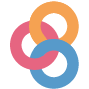)](https://mybinder.org/v2/gh/HD-aula-Literatura/II-2-scraping/374e6a2de8d63642813cfd4aefe3ed7cc8fde722?urlpath=lab%2Ftree%2F02-extraccion-con-python%2F01-extraccion-desde-html.ipynb)


- [Introducción](#intro)
- [Extracción de un poema dado su URL](#extraccion-poema-indiv)
    - [Bajar el contenido de un URL](#bajar-url)
    - [Extraer el contenido](#extraer-contenido)
        - [Obtener los metadatos](#metadatos-indiv)
        - [Obtener el texto del poema](#texto-indiv)
    - [Escribir la información extraída en archivos de salida](#salida-archivo)

# Introducción
<a name="intro"></a>

Veremos cómo efectuar las operaciones siguientes:

- Bajar el contenido (en HTML) de uno o varios URL
- Analizar (parsing) el HTML de forma automática para extraer el contenido de las etiquetas que nos interesan
- Crear archivos de salida con la información extraída y archivos de entrada con información a explotar para la extracción

<html><!--
%TODO% añadir información sobre cómo usar un notebook Jupyter
-->
</html>

## Extraer el contenido y metadatos de un poema, dado sur URL
<a name="extraccion-poema-indiv"></a>

Esta tarea corresponde a lo realizado con OpenRefine en la sección 4.1 del capítulo.

### Bajar el contenido de un URL
<a name="bajar-url"></a>

Para bajar el contenido usamos la biblioteca (conjunto de instrucciones que podemos utilizar desde código Python) [requests](https://requests.readthedocs.io/en/latest/)

En caso de que la biblioteca no esté instalada (lo cual se verá ya que, al intentar usarla, habrá un mensaje de error que lo indique), se puede instalar con `pip install requests` (ver [documentación](https://requests.readthedocs.io/en/latest/))

En el código siguiente, se siguen varias etapas:
- importamos los paquetes o bibliotecas a utilizar
- el URL se asigna, como cadena de caracteres (entre comillas), a una variable llamada `url_pagina` 
- hacemos una petición para obtener el contenido de la página, con `requests.get()`
- obtenemos una respuesta, asignada a la variable `respuesta`. Esta respuesta tiene propiedades interesantes, como las siguientes
  - `.status_code`, que será 200 si el contenido se ha bajado correctamente, u otro código (p. ej. 404 o 500) en caso de error
  - `.text`: devuelve una cadena de texto que representa el contenido de la página. En este caso se trata de contenido HTML (una cadena de texto que representa el HTML de la página).
- Asignamos el contenido de la página (`respuesta.text`) a la variable `html_pagina`. Necesitamos este contenido para crear el árbol HTML que explotaremos para la extracción

In [20]:
import requests
url_pagina = "https://es.wikisource.org/wiki/Una_vi%C3%B1eta"
respuesta = requests.get(url_pagina)
html_pagina = respuesta.text

### Extraer el contenido
<a name="extraer-contenido"></a>

Usaremos el árbol HTML para esto. Ya vimos este tipo de enfoque, con OpenRefine, cuyo lenguaje [GREL](https://docs.openrefine.org/manual/grelfunctions) tiene une instrucción `parseHtml()` para crear el árbol

Con Python, para crear el árbol HTML y extraer el contenido, utilizaremos la "biblioteca" [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/), ampliamente utilizada. Etapas:

- Importamos la biblioteca, con la instrucción `from bs4 import BeautifulSoup`
- En caso de que la biblioteca no esté instalada (lo cual se verá ya que, al intentar usarla, habrá un mensaje de error que lo indique), se puede instalar con `pip install beautifulsoup4` (ver [documentación](https://www.crummy.com/software/BeautifulSoup/bs4/doc/))
- Creamos el árbol HTML a partir de la cadena de texto que lo representa (obtenida más arriva), con `BeautifulSoup(html_pagina)`

Nota: Es habitual llamar "soup" o "sopa" a la representación de contenido HTML analizado con una biblioteca (BeautifulSoup en Python, [JSoup](https://jsoup.org/apidocs/org/jsoup/select/Selector.html) en Java; por cierto OpenRefine en tanto que herramienta creada en Java usa JSoup)

In [23]:
from bs4 import BeautifulSoup
arbol = BeautifulSoup(html_pagina)

#### Obtener los metadatos
<a name="metadatos-indiv"></a>

Una vez que el árbol está disponible, podemos extraer información basándonos en el nombre y atributos de los elementos, como hicimos con OpenRefine en el capítulo.

- Para el elemento de la autora, buscaremos un elemento `<span class='ws-author'>` (es decir, un elemento `span` con un atributo `class` cuyo valor es `ws-author`).

- Para el elemento del título, buscaremos un elemento `<span class='ws-title'>` (es decir, un elemento `span` con un atributo `class` cuyo valor es `ws-title`).

Para hacer esta búsqueda, podemos usar el método `find_all()`, disponible a partir del objeto árbol (que está asignado a la variable `arbol`). Hay varias formas posibles de proceder (ver [documentación](https://www.crummy.com/software/BeautifulSoup/bs4/doc/#find-all)), pero una manera genérica es la siguiente:

```python
arbol.find_all("span", attrs={"class": 'ws-title'})
``` 
Como se ve en el ejemplo, como argumentos a `find_all()` se da el nombre del elemento, y después la sequencia `attrs=` seguida del nombre y valor del atributo buscado, respetando la sintaxis del ejemplo (cadenas entrecomilladas separadas por el signo dos puntos)

<html><!--Comentario si usamos class_ Cabe mencionar que la clave de búsqueda no es `class` sino `class`, ya que la palabra *class* ya tiene otra utilización en Python.--></html> 

Asignaremos el resultado de cada búsqueda a una variable.

In [24]:
autora_ele = arbol.find_all("span", attrs={"class": "ws-author"})
titulo_ele = arbol.find_all("span", attrs={"class": "ws-title"})

Si miramos el contenido de las variables, veremos que, como pasaba con `select()` en las consultas de HTML en OpenRefine, `find_all()` devuelve una lista de valores.

Podemos examinar el contenido de las variables simplemente escribiendo su nombre en una celda de notebook Jupyter o en una consola de Python, o con la función `print()`, pasándole el nombre de la variable como argumento.

In [25]:
# comentario: escribir nombre de variable para ver su valor
autora_ele

[<span class="ws-author">Delmira Agustini</span>]

In [26]:
# ver valor de una variable con print()
print(autora_ele)

[<span class="ws-author">Delmira Agustini</span>]


En tanto que listas, accederemos a su contenido con índices numéricos, y se empieza a contar por cero: `autora_ele[0]`.

Como pasaba con OpenRefine, como salida de nuestro procesamiento no queremos un "elemento", un "nodo" de un árbol con propiedades útiles para su análisis con funciones de manipulación del árbol, sino una cadena de texto. Para esto, podemos usar el método `get_text()` de los elementos tal que analizados por BeautifulSoup. 

In [27]:
autora = autora_ele[0].get_text()
titulo = titulo_ele[0].get_text()

Si inspeccionamos el contenido de las variables con `print()`, veremos que ahora sí contienen una cadena de texto con la información deseada

In [28]:
print(autora)
print(titulo)

Delmira Agustini
Una viñeta


#### Obtener el texto del poema
<a name="texto-indiv"></a>

Pasamos a la extracción del texto. Hay varias formas de hacer esto, algunas muy compactas. Usamos aquí una manera de hacerlo similar a lo que se hizo en el capítulo con OpenRefine.

Se trata de identficar elementos `<div class='poem'>`. Podríamos usar la misma sintaxis que antes, que era `arbol.find_all("div", attrs={"class":"poem"}`, pero cuando el atributo con el que trabajamos es `class`, podemos usar una sintaxis abreviada, como en el ejemplo.

Además de `find_all()`, que devuelve una lista, también hay un método `find()` que devuelve directamente un elemento en vez de una lista. Vamos a usarlo esta vez.

In [29]:
poema_div = arbol.find("div", "poem")

In [30]:
print(poema_div)

<div class="poem">
<p> Tarde sucia de invierno. El caserío,   <br/>
 como si fuera un croquis al creyón,   <br/>
 se hunde en la noche. El humo de un bohío,   <br/>
 que sube en forma de tirabuzón;   <br/>
 <br/>
<br/>
 mancha el paisaje que produce frío,  <br/>
 y debajo de la genuflexión   <br/>
 de la arboleda, somormuja el río   <br/>
 su canción, su somnífera canción.   <br/>
 <br/>
<br/>
 Los labradores, camellón abajo,   <br/>
 retornan fatigosos del trabajo,  <br/>
 como un problema sin definición.   <br/>
 <br/>
<br/>
 Y el dueño del terruño, indiferente,   <br/>
 rápidamente, muy rápidamente,   <br/>
 baja en su coche por el camellón.
</p>
</div>


No hemos llegado todavía al elemento que contiene el poema, que es en realidad un `<p>` bajo el `<div class='poem'>`. Una manera fácil de hacerlo es con el método `find()` de nuevo.

In [31]:
poema_ele = poema_div.find("p")

Para obtener el texto, existe el método `get_text()`. Devuelve el texto como una cadena. A partir del resultado, lo vamos a dividir en versos usando un salto de línea y también vamos a eliminar espacios en blanco de los extremos de cada verso (como hicimos con OpenRefine).

El método para elminiar espacios en blanco de los extremos de una cadena en Python es `strip()` (similar a `trim()` en OpenRefine). También hay `rstrip()` para quitar espacios sólo del final o `lstrip()` par quitar espacios sólo del principio.

Usamos `strip()` dentro de un constructo llamado *comprensión de lista* o *list comprehension*. Como un bucle de tipo *for each* (visto en el capítulo), permite recorrer una secuencia usando una variable que sirve para iterar sobre la secuencia (`verso` en el ejemplo).

Para escribir el resultado en un archivo, vamos a crear una cadena con `"\n".join()`, que concatena los elementos de la lista `texto_versos_limpio` usando un salto de línea como separador. (La sintaxis es diferente a OpenRefine, donde se da como argumento el separador `.join("\n")` en vez de la lista a concatenar).

In [32]:
texto_poema_bruto = poema_ele.get_text()
#arbol.select("div[class=poem] > p")
texto_versos = texto_poema_bruto.split("\n")
texto_versos_limpio = [verso.strip() for verso in texto_versos]
texto_versos_limpio
texto_final = "\n".join(texto_versos_limpio)

In [33]:
print(texto_versos_limpio)
print(texto_final)

['Tarde sucia de invierno. El caserío,', 'como si fuera un croquis al creyón,', 'se hunde en la noche. El humo de un bohío,', 'que sube en forma de tirabuzón;', '', '', 'mancha el paisaje que produce frío,', 'y debajo de la genuflexión', 'de la arboleda, somormuja el río', 'su canción, su somnífera canción.', '', '', 'Los labradores, camellón abajo,', 'retornan fatigosos del trabajo,', 'como un problema sin definición.', '', '', 'Y el dueño del terruño, indiferente,', 'rápidamente, muy rápidamente,', 'baja en su coche por el camellón.', '']
Tarde sucia de invierno. El caserío,
como si fuera un croquis al creyón,
se hunde en la noche. El humo de un bohío,
que sube en forma de tirabuzón;


mancha el paisaje que produce frío,
y debajo de la genuflexión
de la arboleda, somormuja el río
su canción, su somnífera canción.


Los labradores, camellón abajo,
retornan fatigosos del trabajo,
como un problema sin definición.


Y el dueño del terruño, indiferente,
rápidamente, muy rápidamente,
baja 

Nota: Habría una manera compacta de conseguir el texto del poema, usando el método `select()`, cuyo argumento es un selector (una expresión para identificar un conjunto de nodos en un árbol HTML) que identifica los elementos `<p>` que son un hijo directo de un elemento `<div class="poem">`, gracias al operador `>` que significa *hijo directo*:  

```python
arbol.select("div[class=poem] > p")[0].get_text()
```

### Escribir la información extraída en archivos de salida
<a name="salida-archivo"></a>

Vamos a escribir el poema y sus metadatos en un archivo de salida.

Una opción útil es crear un archivo delimitado (CSV, TSV, o de tipo hoja de cálculo). Para esto, se puede usar la biblioteca pandas.

Crearemos una estructura de datos llamada dataframe, con las etapas siguientes:

- El formato a utilizar se ve en la variable `datos`. Se declaran los nombres de las columnas, y, para cada columna, una lista con sus valores (ya hemos visto que los corchetes se suelen usar para representar listas entre otros usos).
- Una vez que los datos están listos, el método `DataFrame` de la biblioteca pandas crea el objeto, con lo que `pd.DataFrame(datos)` crea la dataframe, que se ha asignado a una variable con nombre `df`.

In [35]:
import pandas as pd

datos = {"autora": [autora],
         "titulo": [titulo],
         "textoPoema": [texto_final]} 

df = pd.DataFrame(datos)

In [36]:
df

,autora,titulo,textoPoema
0,Delmira Agustini,Una viñeta,"Tarde sucia de invierno. El caserío,\ncomo si ..."


Vamos a escribir los resultados en archivos de salida con distintos formatos, aprovechando las posibilidades de pandas.

Para crear las rutas (la localización en el disco de cada archivo) usamos el módulo `pathlib`. 

- Se obtiene el directorio donde reside este notebook con `pathlib.Path.cwd()`
- A partir de ahí, se crea el resto de la ruta con `.joinpath()`. Cada etapa de la ruta (cada directorio y el archivo final) se da como argumento  

Para escribir el contenido de las dataframes a los archivos, usamos métodos disponibles desde el objeto dataframe, que aquí se ha llamado `df` (es un nombre habitual).
- El método `to_csv()` escribe archivos delimitados por comas, a no ser que se le dé el argumento `sep="\t"` en cuyo caso utilizará tabulaciones como delimitador (lo que se llama a veces archivo TSV en vez de CSV). Tanto los CSV como los TSV se pueden abrir fácilmente con LibreOffice Calc o con Excel
- El método `to_excel()` crea archivos en formato XLSX (Excel)
- La opción `index=False` se usa ya que de lo contrario, pandas añade una primera columna con el número de fila, lo cual no es informativo para lo que estamos haciendo

In [37]:
import pathlib

directorio_actual = pathlib.Path.cwd()
dir_resultados = directorio_actual.joinpath("resultados", "desde-html")
nombre_fichero = "agustini_poema"
salida_csv = dir_resultados.joinpath(nombre_fichero + ".csv")
salida_tsv = dir_resultados.joinpath(nombre_fichero + ".tsv")
salida_excel = dir_resultados.joinpath(nombre_fichero + ".xlsx")

In [38]:
df.to_csv(salida_csv, index=False)
df.to_csv(salida_tsv, sep="\t", index=False)
df.to_excel(salida_excel, index=False)